# Lab 1: Handle graph data and test a shallow GNN

We will use **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks

Other alternatives:
- [DGL](https://www.dgl.ai/)

Objectives: 
- get familiar with graph data using a simple graph-structured example: **Zachary's karate club network**
- get familiar with GNN architecture: implement a simple architecture

### Load packages

In [12]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
from torch_geometric.utils.convert import to_networkx

## Load dataset

The [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) describes a **social network** where the nodes represent members of a karate club and relations the documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

PyG provides an easy access to this dataset through the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage. <br>
You can easily find some metadata attached to it checking the attributes such as `num_features`...

In [15]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset} is loaded')
print('======================')
# Print basic characteristics of the graph, #{graphs,features,classes}
# TO BE COMPLETED 

print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].num_nodes}')
print(f'Number of edges: {dataset[0].num_edges}')
print(f'Number of features: {dataset[0].num_node_features}')

Dataset: KarateClub() is loaded
Number of graphs: 1
Number of nodes: 34
Number of edges: 156
Number of features: 34


One first step as you usually do with other types of data is characterizing the dataset. Basically, concerning graph, we are interested in the topology of the graph: connectivity, existence of isolated nodes,...

In [19]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
# TO BE COMPLETED

node_degrees = data.edge_index.size(1) / data.num_nodes
isolated_nodes = np.sum(node_degrees) == 0
print(f'Number of isolated nodes: {isolated_nodes}')

# Check if the graph is connected (using networkx for more advanced checks)
G = to_networkx(data, to_undirected=True)  # Convert the graph to a networkx graph
is_connected = nx.is_connected(G)
print(f'Is the graph connected? {is_connected}')

# Additional statistics like the number of components
if not is_connected:
    num_components = nx.number_connected_components(G)
    print(f'Number of connected components: {num_components}')
else:
    print("The graph is fully connected.")

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of isolated nodes: False
Is the graph connected? True
The graph is fully connected.


Inspect the content of node embeddings and edge list:

In [28]:
#TO BE COMPLETED
print("Node Embeddings (Feature Matrix):")
print(data.x)

print("\nEdge List :")
print(data.edge_index)

Node Embeddings (Feature Matrix):
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Edge List :
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33

Visualize the graph:

<class 'networkx.classes.graph.Graph'>
Graph with 34 nodes and 78 edges


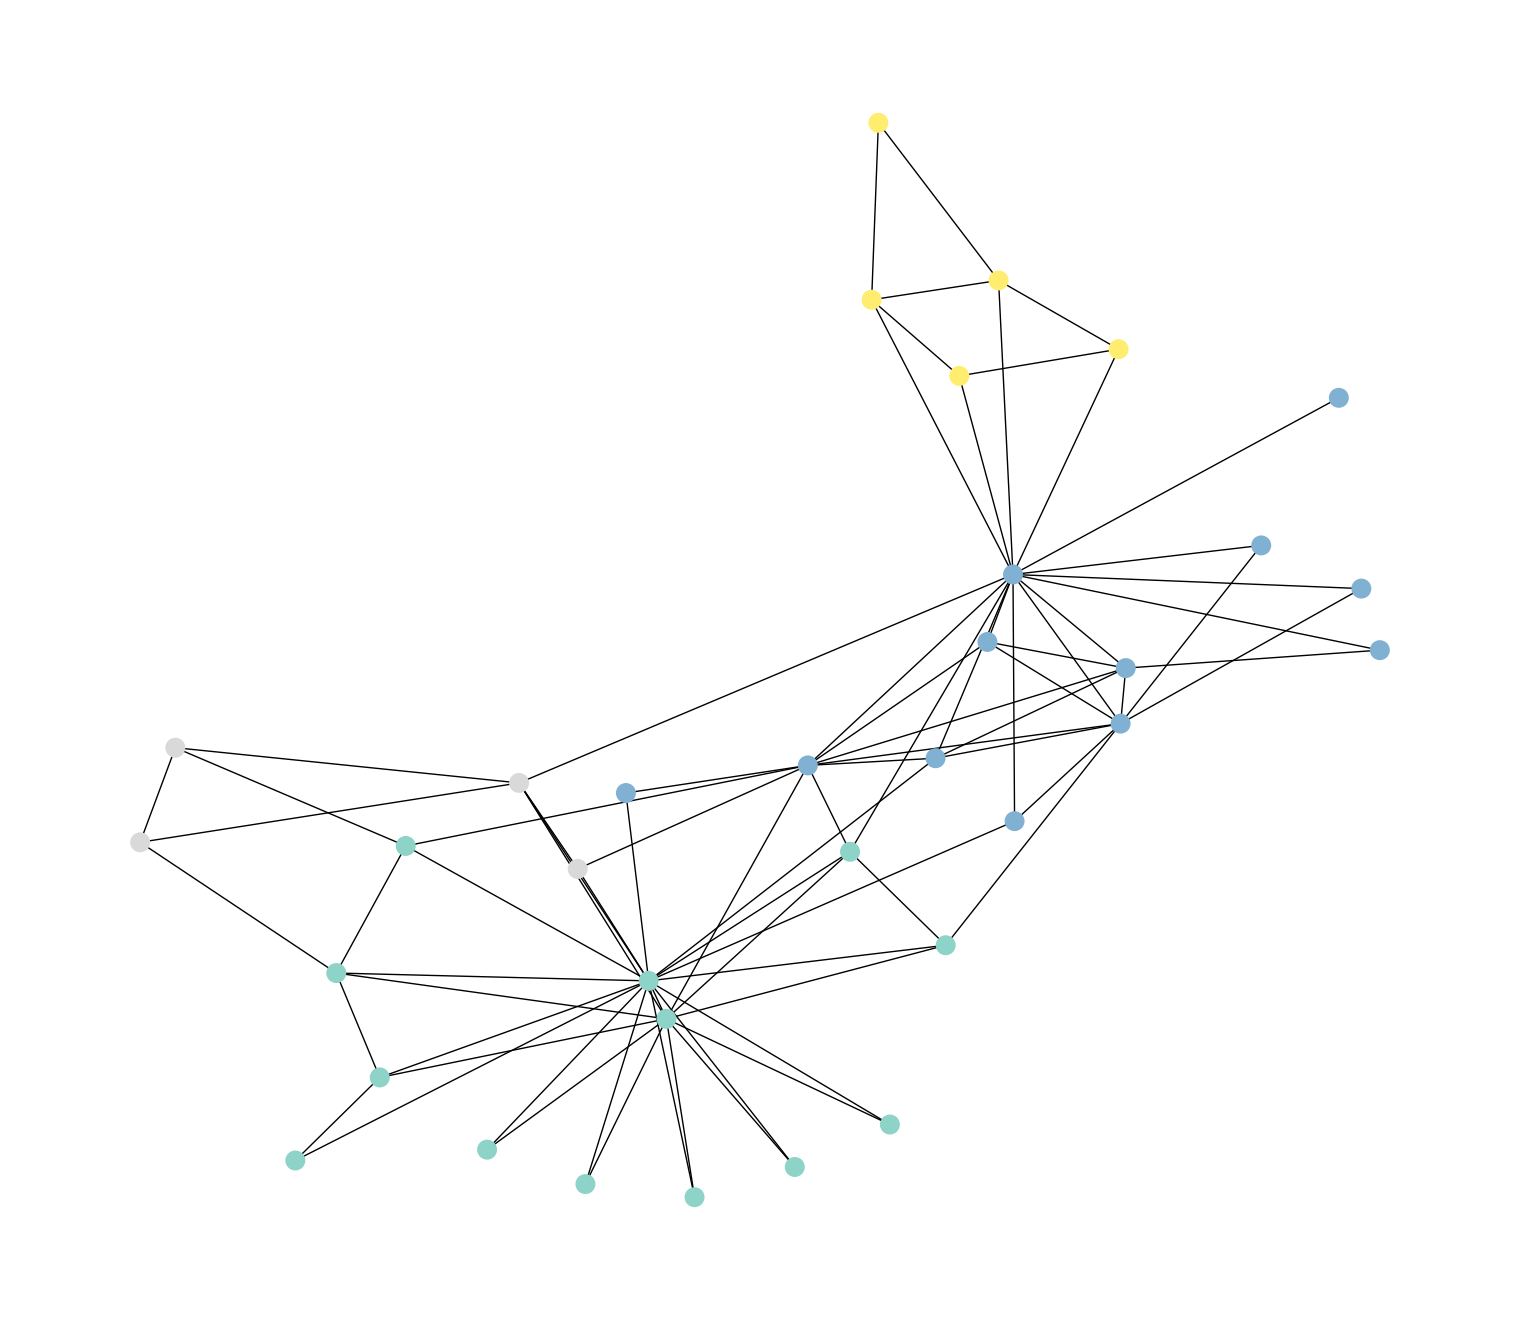

In [25]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
#TO BE COMPLETED
print(type(G))#converted to a directed graph
print(G) 
node_labels = data.y.numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13))
nx.draw(G, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6) #colors are attributed based on the labels
plt.show()

## Implementing a Graph Neural Network for node classification task

Define the architecture of a two layers GNN (1 hidden layer):

In [61]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 64) 
        self.conv2 = GCNConv(64, 128) 
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 32)
        self.conv5 = GCNConv(32, 16)
        self.conv6 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 16)
  (conv6): GCNConv(16, 4)
)


Define your training and evaluation loops

In [62]:
# Define train/test split manually with native slicing [450:]
num_nodes = data.num_nodes
split_idx = int(0.8 * num_nodes)  # 80% of the nodes for training

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 80% for training (from index 0 to `split_idx`)
train_mask[:split_idx] = True

# 20% for testing (from index `split_idx` to the end)
test_mask[split_idx:] = True

# Add train and test mask to data object
data.train_mask = train_mask
data.test_mask = test_mask

In [63]:
# TO BE COMPLETED
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) #use the training split predifined through attribute train_mask
    loss.backward()
    optimizer.step()

In [64]:
model.eval()#on the test split pre-defined through attribute test_mask
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8571


Futher steps:
1. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

2. You can try to use different GNN layers to see how model performance changes.